#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier



* 함수 생성

In [3]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [4]:
#데이터 불러오기
data_path = "./data01_train.csv"
data = pd.read_csv(data_path)
data.drop('subject', axis=1, inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [5]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [6]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [7]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


#### 2) 기본 정보 조회

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='tBodyAcc-mean()-Y', ylabel='Density'>

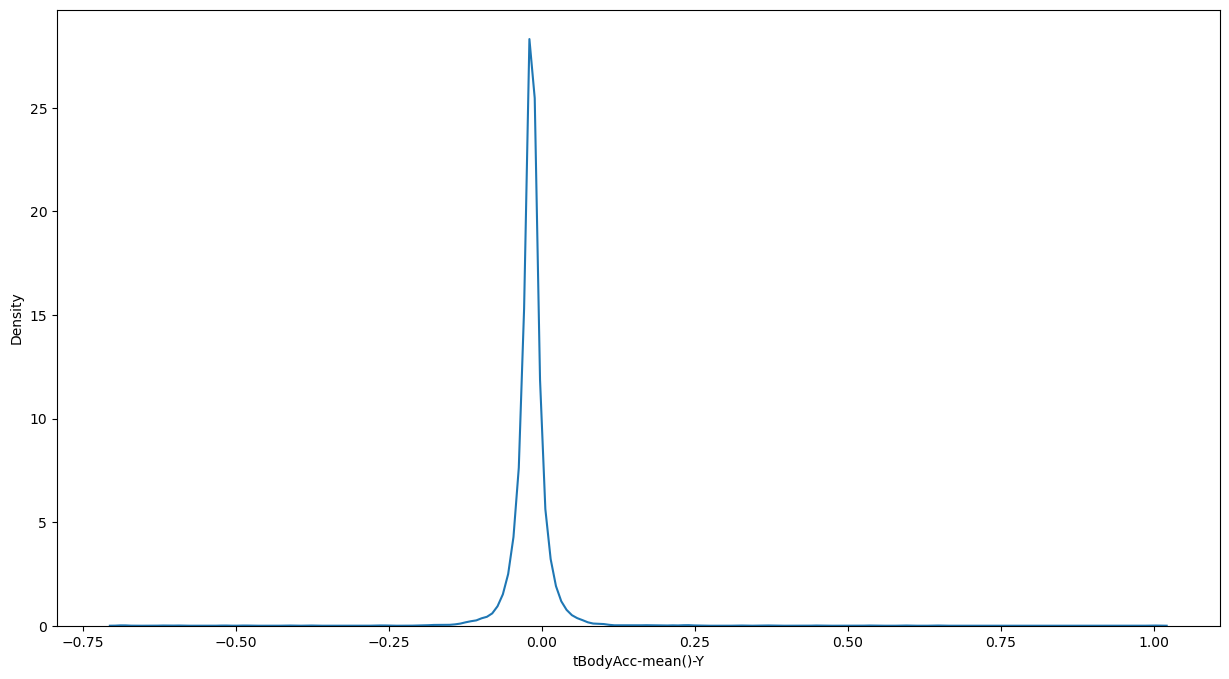

In [8]:
# kde로 tBodyAcc-mean()-Y 분포 확인
var = 'tBodyAcc-mean()-Y'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, common_norm = False)

In [9]:
# 전체 데이터의 이변량 분석 (corr)
# Activity 숫자로 변환
data['Activity_num'] = data['Activity'].map({'WALKING':0,
                                                 'WALKING_UPSTAIRS':1,
                                                 'WALKING_DOWNSTAIRS':2,
                                                 'LAYING':3,
                                                 'STANDING':4,
                                                 'SITTING':5})
data = data.drop(['Activity'],axis =1)
print(data.dtypes)

tBodyAcc-mean()-X                       float64
tBodyAcc-mean()-Y                       float64
tBodyAcc-mean()-Z                       float64
tBodyAcc-std()-X                        float64
tBodyAcc-std()-Y                        float64
                                         ...   
angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity_num                              int64
Length: 562, dtype: object


In [10]:
# 전체 데이터의 이변량 분석 (corr)
data_corr = data.corr()
data_corr

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity_num
tBodyAcc-mean()-X,1.000000,0.203297,-0.266383,0.012067,-0.018489,-0.040405,0.018367,-0.019752,-0.043303,0.048725,...,-0.012101,-0.011490,-0.567455,0.019251,0.034065,0.030968,-0.027010,0.028177,0.019025,0.012249
tBodyAcc-mean()-Y,0.203297,1.000000,-0.145709,-0.049467,-0.052489,-0.058499,-0.048703,-0.053018,-0.058559,-0.038544,...,-0.003101,-0.003467,0.076995,-0.013001,0.019670,0.074955,0.000039,0.002376,-0.022329,0.065975
tBodyAcc-mean()-Z,-0.266383,-0.145709,1.000000,-0.024839,-0.017613,-0.016924,-0.023323,-0.015794,-0.012575,-0.040397,...,0.018155,0.018234,0.056806,-0.036749,-0.054069,-0.035593,0.007045,-0.017900,-0.019169,0.045042
tBodyAcc-std()-X,0.012067,-0.049467,-0.024839,1.000000,0.927809,0.851841,0.998656,0.921154,0.846308,0.981190,...,0.151555,0.116425,-0.043069,-0.032145,0.016542,-0.024749,-0.373500,0.470834,0.392843,-0.729811
tBodyAcc-std()-Y,-0.018489,-0.052489,-0.017613,0.927809,1.000000,0.893995,0.923386,0.997320,0.892843,0.916853,...,0.209119,0.177232,-0.027671,-0.022181,-0.012927,-0.015237,-0.380258,0.521249,0.429141,-0.814393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",0.030968,0.074955,-0.035593,-0.024749,-0.015237,-0.004077,-0.025205,-0.013152,-0.004784,-0.028239,...,-0.018015,-0.015179,-0.027075,0.029856,-0.113677,1.000000,0.012598,0.005132,0.001242,-0.005633
"angle(X,gravityMean)",-0.027010,0.000039,0.007045,-0.373500,-0.380258,-0.346237,-0.370024,-0.376665,-0.348279,-0.385300,...,-0.088810,-0.080113,0.012382,0.020700,-0.001992,0.012598,1.000000,-0.783107,-0.639201,0.105635
"angle(Y,gravityMean)",0.028177,0.002376,-0.017900,0.470834,0.521249,0.473572,0.466287,0.522401,0.474880,0.478832,...,0.092383,0.080726,-0.000955,-0.013508,-0.013863,0.005132,-0.783107,1.000000,0.590883,-0.312724
"angle(Z,gravityMean)",0.019025,-0.022329,-0.019169,0.392843,0.429141,0.480593,0.389196,0.427486,0.477848,0.401217,...,0.056005,0.049690,-0.004422,-0.014844,-0.021702,0.001242,-0.639201,0.590883,1.000000,-0.265984


<AxesSubplot:title={'center':'subset1'}>

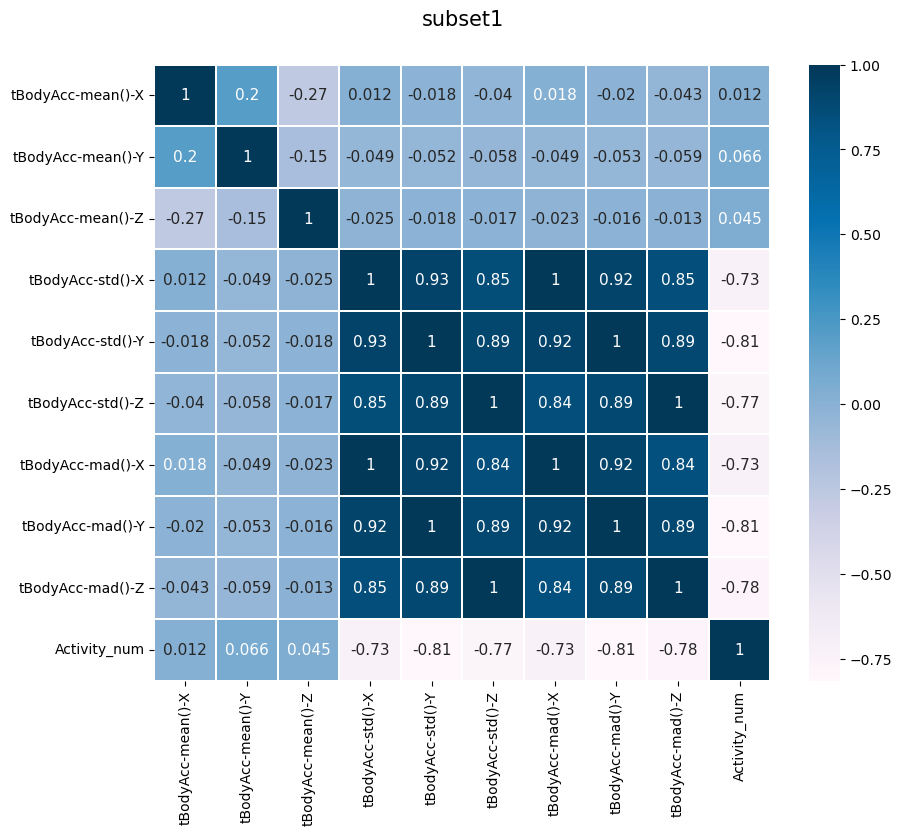

In [11]:
# 변수를 줄여서 이변량 시각화 하기 
subset = data[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z' , 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y' , 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X' , 'tBodyAcc-mad()-Y' , 'tBodyAcc-mad()-Z' , "Activity_num"]]
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("subset1", y = 1.05, size = 15)
sns.heatmap(subset.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 11})

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [12]:
# 데이터 분할을 위한 전처리
target = 'Activity_num'
x = data.drop(labels=[target], axis = 1)
y = data.loc[:, target]

In [13]:
x

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,0.052914,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.325461,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.362439,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.031915,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920


### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
#MIN-MAX 스케일링
scaler = MinMaxScaler()

# 데이터 스케일링 후 데이터 프라임으로 생성
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x 

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.526878,0.401033,0.448319,0.005507,0.019335,0.016125,0.005500,0.018720,0.017175,0.035126,...,0.488133,0.249657,0.093564,0.472577,0.477891,0.654361,0.537449,0.201725,0.900647,0.578396
1,0.511749,0.396653,0.450918,0.005224,0.002718,0.006117,0.004906,0.002821,0.006221,0.031332,...,0.375973,0.376595,0.156521,0.462253,0.694229,0.117569,0.887502,0.680309,0.156150,0.420272
2,0.520362,0.397878,0.445641,0.001140,0.009789,0.002830,0.001033,0.008760,0.002492,0.028708,...,0.708258,0.225505,0.087117,0.494210,0.237489,0.054098,0.511768,0.084172,0.813468,0.478444
3,0.527733,0.385400,0.424823,0.384137,0.518471,0.330830,0.363222,0.515313,0.326042,0.504144,...,0.531583,0.495352,0.301955,0.365002,0.806402,0.874258,0.464438,0.153833,0.870783,0.551238
4,0.597564,0.426728,0.545615,0.544245,0.466164,0.305633,0.494765,0.452314,0.326814,0.792066,...,0.497705,0.417223,0.223002,0.471641,0.077366,0.012683,0.056187,0.149176,0.855762,0.564555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.519354,0.399138,0.434013,0.002977,0.030931,0.041172,0.002869,0.033852,0.045956,0.031890,...,0.532643,0.342081,0.158131,0.476425,0.369282,0.304459,0.061314,0.044320,0.753647,0.535461
5877,0.462416,0.414401,0.447413,0.436516,0.458287,0.336149,0.403739,0.452190,0.352357,0.539322,...,0.675157,0.181148,0.061611,0.859210,0.811576,0.934035,0.277715,0.156635,0.881634,0.472671
5878,0.513228,0.395601,0.446280,0.004348,0.005200,0.004678,0.003807,0.005372,0.004382,0.031951,...,0.694492,0.193850,0.057709,0.524518,0.614370,0.842747,0.392437,0.819464,0.380712,0.206199
5879,0.476525,0.377925,0.439500,0.479313,0.549190,0.207188,0.449643,0.519943,0.222646,0.609907,...,0.521662,0.597411,0.483596,0.626061,0.775871,0.028132,0.068685,0.142611,0.874641,0.507571


### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

# (1) 알고리즘1 : Random Forest

In [16]:
#생성
model = RandomForestClassifier()

#학습
model.fit(x_train, y_train)
pred = model.predict(x_val)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


accuracy : 0.975070821529745
[[288   4   5   0   0   0]
 [  2 249   1   0   0   0]
 [  3   1 217   0   0   0]
 [  0   1   0 344   0   0]
 [  0   0   0   0 316  15]
 [  0   0   0   0  12 307]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       297
           1       0.98      0.99      0.98       252
           2       0.97      0.98      0.98       221
           3       1.00      1.00      1.00       345
           4       0.96      0.95      0.96       331
           5       0.95      0.96      0.96       319

    accuracy                           0.98      1765
   macro avg       0.97      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.037054
1,"angle(Y,gravityMean)",0.029089
2,tGravityAcc-max()-Y,0.027883
3,tGravityAcc-energy()-X,0.026796
4,tGravityAcc-mean()-Y,0.025459
...,...,...
556,"fBodyAccJerk-bandsEnergy()-57,64",0.000070
557,fBodyAccJerk-min()-Z,0.000070
558,fBodyBodyGyroJerkMag-entropy(),0.000069
559,fBodyAccJerk-entropy()-Y,0.000059


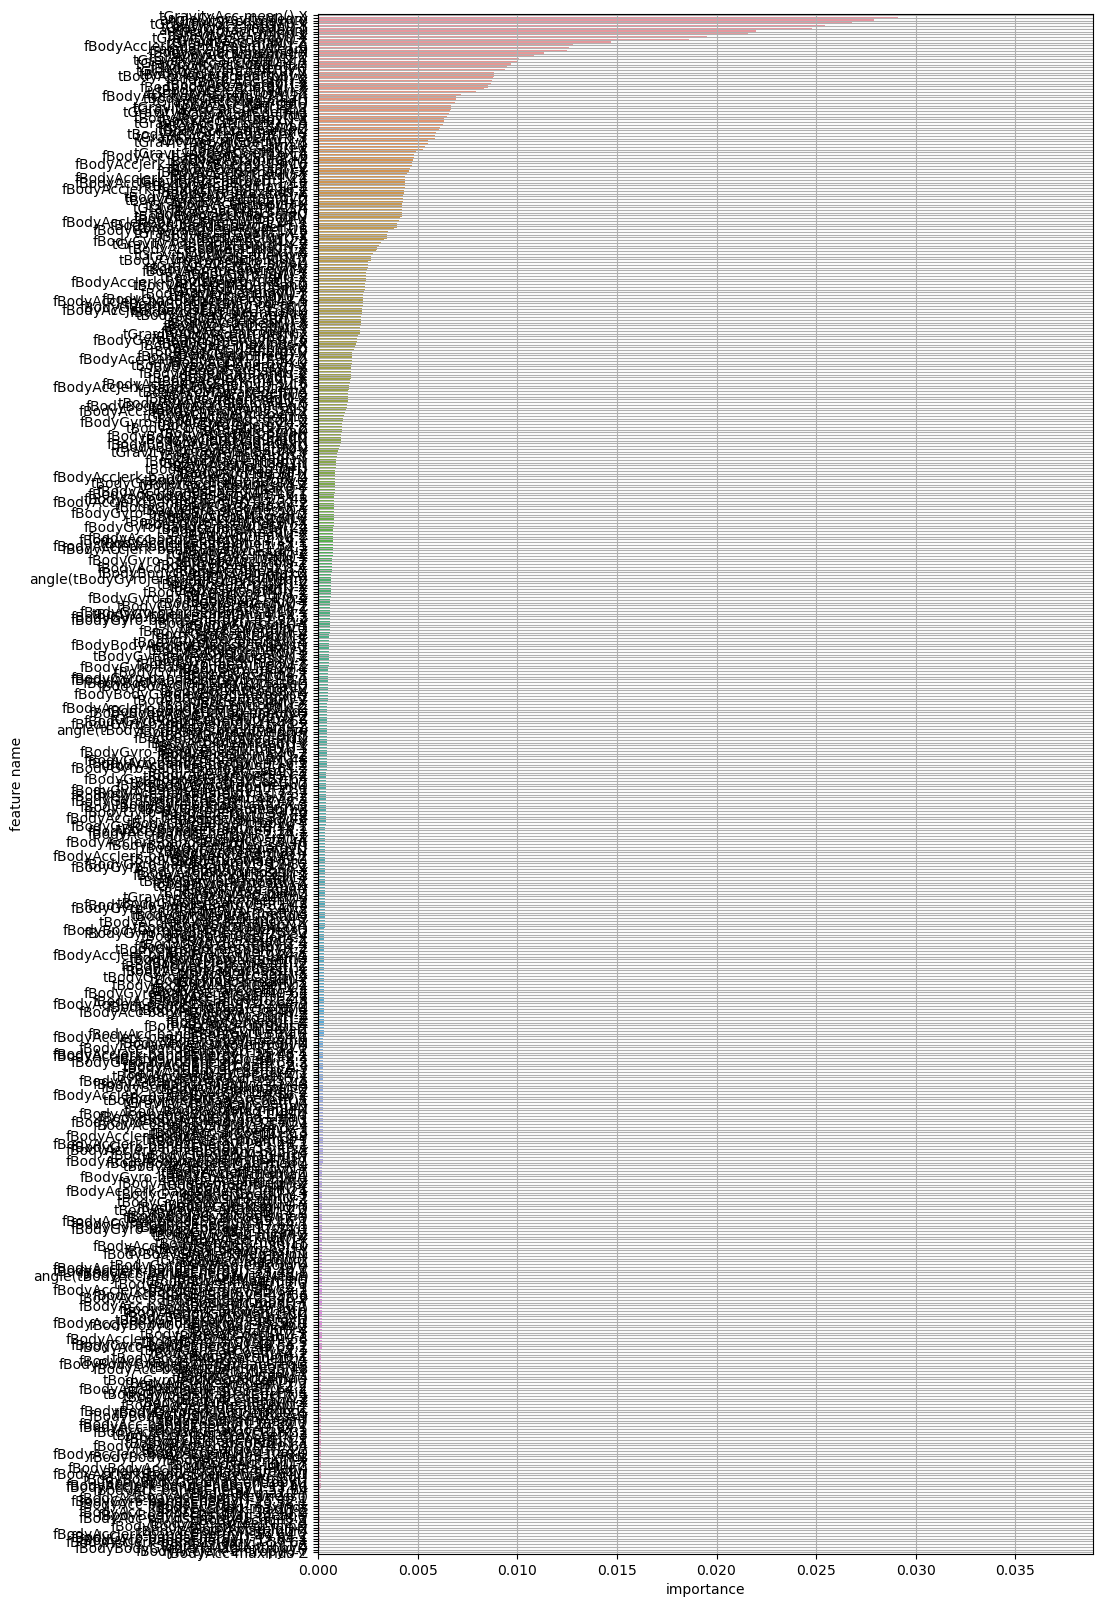

In [17]:
# 변수 중요도 추출 상대적 중요도
r1 = plot_feature_importance(model.feature_importances_, list(x_train), False)
r1

In [18]:
# 상위 20개의 특징을 추출
top_20_features = r1['feature_name'][:20]

# 기존 데이터 프레임 df에서 상위 20개의 특징만 추출하여 새로운 데이터 프레임 생성
new_x = x[top_20_features]
new_x

,tGravityAcc-mean()-X,"angle(Y,gravityMean)",tGravityAcc-max()-Y,tGravityAcc-energy()-X,tGravityAcc-mean()-Y,"angle(X,gravityMean)",tGravityAcc-min()-Y,tGravityAcc-max()-X,tGravityAcc-energy()-Y,tGravityAcc-min()-X,tGravityAcc-max()-Z,"fBodyAccJerk-bandsEnergy()-1,8","angle(Z,gravityMean)",fBodyAccJerk-mean()-X,fBodyAccMag-mad(),tGravityAcc-energy()-Z,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,2",tGravityAccMag-std(),fBodyAccMag-energy()
0,0.939996,0.900647,0.084381,0.847111,0.114889,0.201725,0.148733,0.902470,0.112032,0.945608,0.396727,0.000022,0.578396,0.006256,0.009751,0.044205,0.372120,0.637997,0.009927,0.000208
1,0.418889,0.156150,0.935031,0.053734,0.950923,0.680309,0.960101,0.397433,0.857254,0.448509,0.614962,0.000020,0.420272,0.005181,0.004933,0.051803,0.619579,0.480211,0.005001,0.000081
2,0.986800,0.813468,0.203944,0.964773,0.235228,0.084172,0.269332,0.945616,0.023478,0.992753,0.535593,0.000002,0.478444,0.002532,0.004213,0.005256,0.652204,0.405213,0.004074,0.000062
3,0.966872,0.870783,0.126143,0.913741,0.154713,0.153833,0.186498,0.928829,0.075452,0.971781,0.437069,0.115185,0.551238,0.341899,0.255198,0.018153,0.392594,0.632320,0.295833,0.089839
4,0.953344,0.855762,0.176305,0.879993,0.178920,0.149176,0.194289,0.929016,0.057392,0.950630,0.460717,0.244816,0.564555,0.420401,0.603115,0.031558,0.139757,0.780672,0.631104,0.401133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.990544,0.753647,0.294301,0.974518,0.319908,0.044320,0.344852,0.949340,0.000692,0.996172,0.462358,0.000011,0.535461,0.004640,0.019690,0.008028,0.212868,0.729625,0.023094,0.000785
5877,0.958404,0.881634,0.115250,0.892480,0.141807,0.156635,0.176487,0.921564,0.086519,0.960225,0.546663,0.121951,0.472671,0.331067,0.384461,0.007837,0.382702,0.623864,0.406952,0.168300
5878,0.223075,0.380712,0.775416,0.000728,0.794759,0.819464,0.809293,0.207527,0.476680,0.262386,0.872416,0.000032,0.206199,0.007129,0.003823,0.555779,0.532233,0.473314,0.004249,0.000065
5879,0.963885,0.874641,0.122627,0.906216,0.151406,0.142611,0.175178,0.926022,0.078266,0.965958,0.507802,0.211998,0.507571,0.359203,0.365367,0.000167,0.182127,0.736315,0.427810,0.185748


In [19]:
# 상위 20개의 특징으로 모델 학습
x_train, x_val, y_train, y_val = train_test_split(new_x, y, test_size = .3)

#생성
model = RandomForestClassifier()

#학습
model.fit(x_train, y_train)
pred = model.predict(x_val)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


accuracy : 0.9716713881019831
[[271   3   3   0   0   0]
 [  2 264   0   0   0   0]
 [ 13   4 230   0   0   0]
 [  0   0   0 327   0   0]
 [  0   0   0   0 311  20]
 [  0   0   0   0   5 312]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       277
           1       0.97      0.99      0.98       266
           2       0.99      0.93      0.96       247
           3       1.00      1.00      1.00       327
           4       0.98      0.94      0.96       331
           5       0.94      0.98      0.96       317

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765



/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


# (2) 알고리즘2 : XGBoost

In [20]:
# 데이터분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3)

# XGBoost 모델 생성
model = xgb.XGBClassifier()

# 모델 학습
model.fit(x_train, y_train)

# 예측
pred = model.predict(x_val)

# 성능 평가
print('Accuracy:', accuracy_score(y_val, pred))
print('=' * 60)
print('Confusion Matrix:')
print(confusion_matrix(y_val, pred))
print('=' * 60)
print('Classification Report:')
print(classification_report(y_val, pred))

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  r

Accuracy: 0.9835694050991501
Confusion Matrix:
[[303   4   5   0   0   0]
 [  2 258   1   0   0   0]
 [  0   2 240   0   0   0]
 [  0   0   0 337   0   0]
 [  0   0   0   0 306   6]
 [  0   1   0   0   8 292]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       312
           1       0.97      0.99      0.98       261
           2       0.98      0.99      0.98       242
           3       1.00      1.00      1.00       337
           4       0.97      0.98      0.98       312
           5       0.98      0.97      0.97       301

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  r

# (3) 알고리즘3 : SVM

In [21]:
# SVM 모델 생성
svm = SVC(kernel='linear')

# SVM 모델 학습
svm.fit(x_train, y_train)

# 검증 데이터 예측
pred = svm.predict(x_val)

# 성능 평가
print('Accuracy:', accuracy_score(y_val, pred))
print('=' * 60)
print('Confusion Matrix:')
print(confusion_matrix(y_val, pred))
print('=' * 60)
print('Classification Report:')
print(classification_report(y_val, pred))

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 0.9875354107648725
Confusion Matrix:
[[312   0   0   0   0   0]
 [  0 261   0   0   0   0]
 [  0   0 242   0   0   0]
 [  0   0   0 337   0   0]
 [  0   0   0   0 300  12]
 [  0   1   0   0   9 291]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       261
           2       1.00      1.00      1.00       242
           3       1.00      1.00      1.00       337
           4       0.97      0.96      0.97       312
           5       0.96      0.97      0.96       301

    accuracy                           0.99      1765
   macro avg       0.99      0.99      0.99      1765
weighted avg       0.99      0.99      0.99      1765



# (4) 알고리즘4 : KNN

In [21]:
# KNN 모델 생성
knn = KNeighborsClassifier(n_neighbors=3)  # K값 설정

# KNN 모델 학습
knn.fit(x_train, y_train)

# 검증 데이터 예측
pred = knn.predict(x_val)

# 성능 평가
print('Accuracy:', accuracy_score(y_val, pred))
print('=' * 60)
print('Confusion Matrix:')
print(confusion_matrix(y_val, pred))
print('=' * 60)
print('Classification Report:')
print(classification_report(y_val, pred))

/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kimboseong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 0.9660056657223796
Confusion Matrix:
[[297   0   0   0   0   0]
 [  1 261   0   0   0   0]
 [  0   1 248   0   0   0]
 [  0   0   0 334   0   0]
 [  0   0   0   0 294  10]
 [  0   0   0   2  46 271]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       262
           2       1.00      1.00      1.00       249
           3       0.99      1.00      1.00       334
           4       0.86      0.97      0.91       304
           5       0.96      0.85      0.90       319

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765

